In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import gc
import pickle

In [57]:
def create_sequences_3(df, window_size=30, test_size=0.1, val_size=0.1):
    """
    Generates scaled sequences and splits into training, validation, and testing sets.
    
    Parameters:
    df (pd.DataFrame): The input dataframe with engine data.
    window_size (int): Number of time steps in each sequence.
    test_size (float): Fraction of data to reserve for testing.
    val_size (float): Fraction of data to reserve for validation.

    Returns:
    X_train, X_val, X_test, y_train, y_val, y_test, feature_scaler, target_scaler (np.ndarray): 
    Arrays of train/val/test sequences and targets, feature and target scalers.
    """
    features = [col for col in df.columns if col not in ['id', 'cycle', 'remaining_cycles']]
    target_column = 'remaining_cycles'
    
    # Initialize scalers
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()
    
    # Lists to collect sequences and targets
    X_sequences = []
    y_targets = []
    
    # Group by engine ID and create sliding windows before splitting
    for engine_id, engine_data in df.groupby('id'):
        engine_data = engine_data.sort_values(by='cycle')  # Sort by cycle to keep temporal order
        
        # Create sliding windows
        for i in range(len(engine_data) - window_size):
            X_sequence = engine_data[features].iloc[i:i + window_size].values
            y_target = engine_data[target_column].iloc[i + window_size - 1]  # Target is RUL of last cycle in window
            
            X_sequences.append(X_sequence)
            y_targets.append(y_target)
    
    # Convert to numpy arrays
    X_sequences = np.array(X_sequences)
    y_targets = np.array(y_targets)
    
    # Split data into training+validation and testing
    X_train_val, X_test, y_train_val, y_test = train_test_split(X_sequences, y_targets, test_size=test_size, random_state=42)
    
    # Further split the training+validation data into training and validation
    val_ratio_adjusted = val_size / (1 - test_size)  # Adjust validation size proportionally
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_ratio_adjusted, random_state=42)
    
    # Fit the scalers on the training data
    feature_scaler.fit(X_train.reshape(-1, X_train.shape[2]))  # Reshape for fitting scaler
    target_scaler.fit(y_train.reshape(-1, 1))  # Reshape target for fitting scaler
    
    # Apply the scalers to the data
    X_train = feature_scaler.transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)  # Reshape back after scaling
    X_val = feature_scaler.transform(X_val.reshape(-1, X_val.shape[2])).reshape(X_val.shape)
    X_test = feature_scaler.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)
    
    y_train = target_scaler.transform(y_train.reshape(-1, 1))
    y_val = target_scaler.transform(y_val.reshape(-1, 1))
    y_test = target_scaler.transform(y_test.reshape(-1, 1))
    
    return X_train, X_val, X_test, y_train, y_val, y_test, feature_scaler, target_scaler


In [58]:
with open('history_array.pkl', 'rb') as f:
    history_arrays = pickle.load(f)

# 'history_arrays' will now be a list of dictionaries, each containing the training history for each model
window_size = [10,15,20,25,30,35,40,45,50]

In [59]:
# Example: Plotting loss for the first model in the array
import matplotlib.pyplot as plt
def plot(history_arrays,window_size,i,metric,val_metric):
    first_model_history = history_arrays[i]
    plt.plot(first_model_history[metric])
    plt.plot(first_model_history[val_metric])
    plt.title(f'Window Length {window_size[i]} Model {metric.upper()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.upper())
    plt.ylim(0,0.2)
    plt.legend(['Train', 'Validation'])
    plt.show()


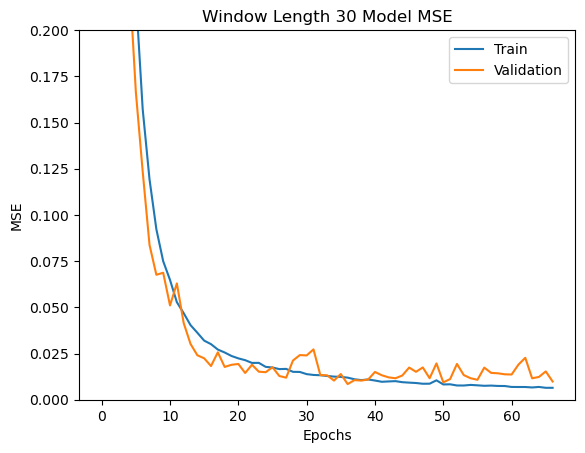

In [60]:
plot(history_arrays,window_size,4,'mse','val_mse')

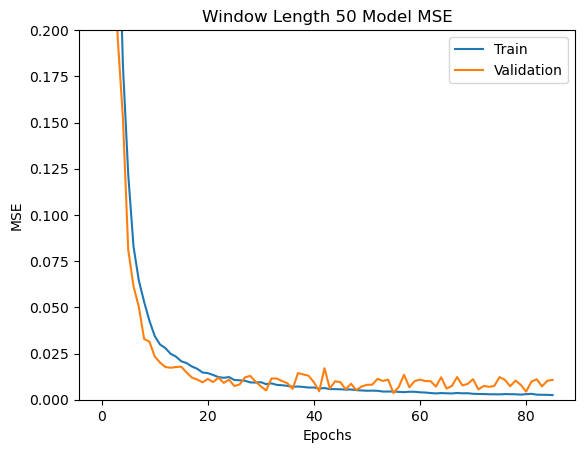

In [61]:
plot(history_arrays,window_size,8,'mse','val_mse')

In [62]:
plot(history_arrays,window_size,1)

TypeError: plot() missing 2 required positional arguments: 'metric' and 'val_metric'

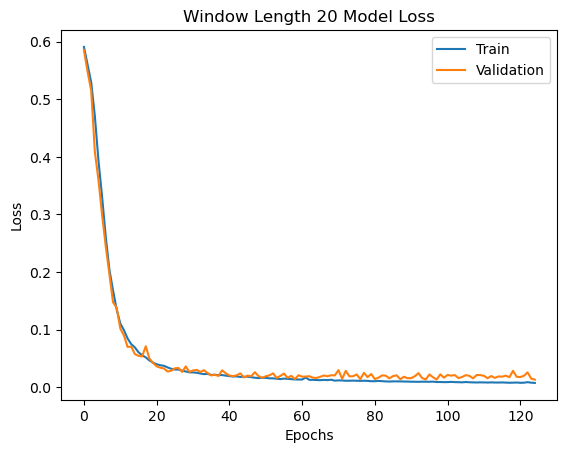

In [ ]:
plot(history_arrays,window_size,2)

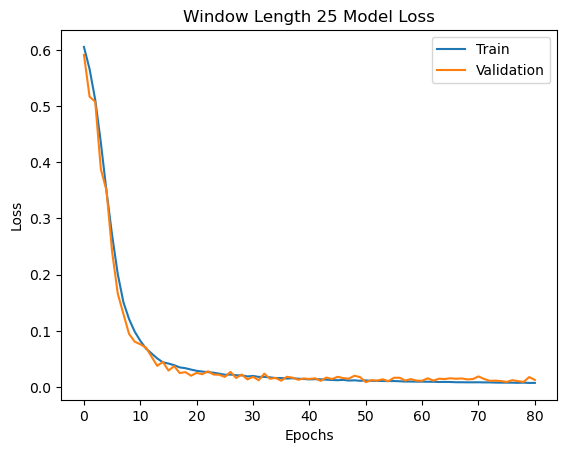

In [ ]:
plot(history_arrays,window_size,3)

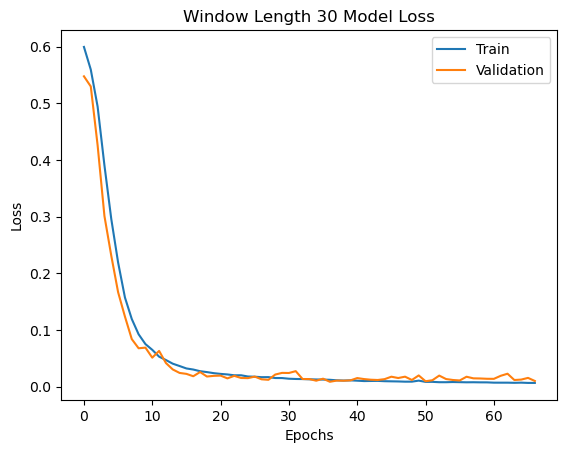

In [ ]:
plot(history_arrays,window_size,4)

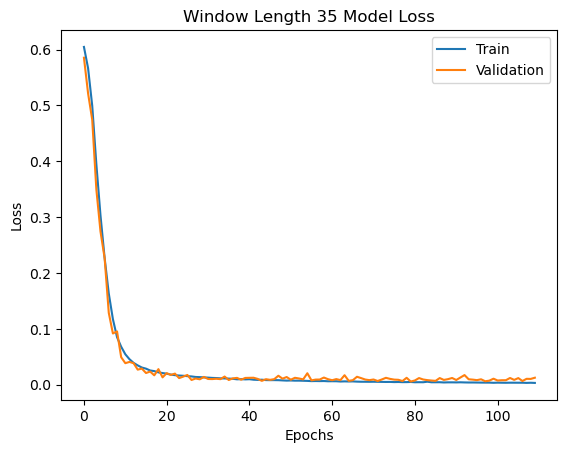

In [ ]:
plot(history_arrays,window_size,5)

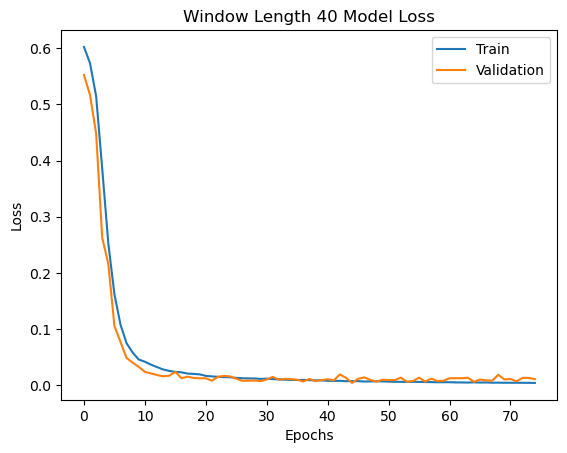

In [ ]:
plot(history_arrays,window_size,6)

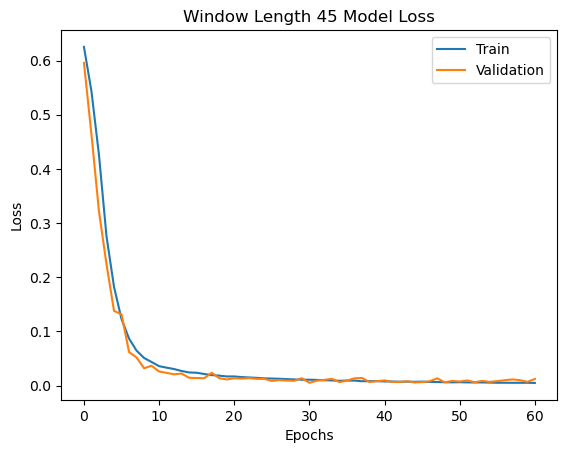

In [ ]:
plot(history_arrays,window_size,7)

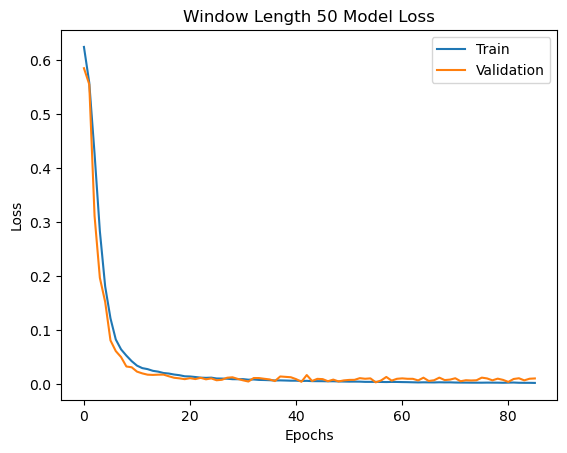

In [ ]:
plot(history_arrays,window_size,8)

In [ ]:
def plot_residuals_hist(model, X_test, y_test, bins=30):
    """
    Plots histogram of residuals of a TensorFlow model.
    
    Args:
        model: Trained TensorFlow model.
        X_test: Test input data.
        y_test: True labels for test data.
        bins: Number of bins for the histogram (default is 30).
    """
    y_pred = model.predict(X_test)  # Predicted values
    residuals = y_test - y_pred  # Calculate residuals

    # Flatten arrays for plotting if needed
    residuals_flat = np.ravel(residuals)

    # Create the residuals histogram
    plt.figure(figsize=(8, 6))
    plt.hist(residuals_flat, bins=bins, alpha=0.7, edgecolor='black')
    plt.axvline(0, color='red', linestyle='--', linewidth=1)  # Reference line at 0
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Residuals Histogram')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

In [ ]:
def dataReader():
    df = pd.read_excel("D:\\Projects\\BDA\\aircraft_reliability\\data\\PM_train.xlsx")
    df_truth = pd.read_excel("D:\\Projects\\BDA\\aircraft_reliability\\data\\PM_truth.xlsx")
    df_merged = pd.merge(df, df_truth, on='id')
    # Step 1: Get the maximum cycle for each engine
    max_cycle_per_engine = df.groupby('id')['cycle'].max().reset_index()
    max_cycle_per_engine.columns = ['id', 'max_cycle']

    # Step 2: Merge the maximum cycle with the df_truth to get the actual failure cycle
    df_merged = pd.merge(max_cycle_per_engine, df_truth, on='id')

    # Step 3: Calculate the actual failure cycle (when engine will fail)
    df_merged['failure_cycle'] = df_merged['max_cycle'] + df_merged['more']

    # Step 4: Merge this back with the main DataFrame to compute remaining cycles
    df = pd.merge(df, df_merged[['id', 'failure_cycle']], on='id')

    # Step 5: Calculate remaining cycles for each row by subtracting the current cycle from the failure cycle
    df['remaining_cycles'] = df['failure_cycle'] - df['cycle']
    df = df.drop('failure_cycle',axis=1)
    return df

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
df = dataReader()

In [ ]:
# Adjusted evaluation function
def evaluate_model(model, X_test, y_test,type,scaler):
    predictions = model.predict(X_test)
    if predictions.shape[0] != y_test.shape[0]:
        # Trimming to the minimum size for consistency
        min_len = min(predictions.shape[0], y_test.shape[0])
        predictions = predictions[:min_len]
        y_test = y_test[:min_len]
    rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)), scaler.inverse_transform(predictions.reshape(-1,1))))
    mae = mean_absolute_error(scaler.inverse_transform(y_test.reshape(-1,1)), scaler.inverse_transform(predictions.reshape(-1,1)))
    print(f"{type} Model Evaluation - RMSE,MAE: {rmse:.2f}&{mae:.2f}")
    return predictions, rmse, mae

In [ ]:
i=30
model = tf.keras.models.load_model('models/model_winLen30.keras')
X_train, X_val, X_test, y_train, y_val, y_test, scaler,yscaler= create_sequences_3(df, window_size=i, test_size=0.2)
preds,rmse_30,mae_30 = evaluate_model(model,X_test,y_test,'window len 30 ',yscaler)

window len 30  Model Evaluation - RMSE,MAE: 7.17&5.20


In [ ]:
i=50
model = tf.keras.models.load_model(f'models/model_winLen{i}.keras')
X_train, X_val, X_test, y_train, y_val, y_test, scaler,yscaler= create_sequences_3(df, window_size=i, test_size=0.2)
preds,rmse_50,mae_50 = evaluate_model(model,X_test,y_test,f'window len {i} ',yscaler)

window len 50  Model Evaluation - RMSE,MAE: 4.16&3.11


In [ ]:
i=10
model = tf.keras.models.load_model(f'models/model_winLen{i}.keras')
X_train, X_val, X_test, y_train, y_val, y_test, scaler,yscaler= create_sequences_3(df, window_size=i, test_size=0.2)
preds,rmse_50,mae_50 = evaluate_model(model,X_test,y_test,f'window len {i} ',yscaler)

window len 10  Model Evaluation - RMSE,MAE: 23.04&16.28


In [ ]:
i=25
model = tf.keras.models.load_model(f'models/model_winLen{i}.keras')
X_train, X_val, X_test, y_train, y_val, y_test, scaler,yscaler= create_sequences_3(df, window_size=i, test_size=0.2)
preds,rmse_50,mae_50 = evaluate_model(model,X_test,y_test,f'window len {i} ',yscaler)

window len 25  Model Evaluation - RMSE,MAE: 7.28&5.44


In [ ]:
i=30
model = tf.keras.models.load_model(f'models/model_winLen{i}.keras')
X_train, X_val, X_test, y_train, y_val, y_test, scaler,yscaler= create_sequences_3(df, window_size=i, test_size=0.2)
preds,rmse_50,mae_50 = evaluate_model(model,X_test,y_test,f'window len {i} ',yscaler)

window len 30  Model Evaluation - RMSE,MAE: 7.17&5.20


In [ ]:
i=35
model = tf.keras.models.load_model(f'models/model_winLen{i}.keras')
X_train, X_val, X_test, y_train, y_val, y_test, scaler,yscaler= create_sequences_3(df, window_size=i, test_size=0.2)
preds,rmse_50,mae_50 = evaluate_model(model,X_test,y_test,f'window len {i} ',yscaler)

c:\Users\anush\.conda\envs\mlEnv_2\lib\site-packages\sklearn\preprocessing\_data.py:1020: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


window len 35  Model Evaluation - RMSE,MAE: 5.67&4.04


In [ ]:
for i in [40,45,50]:

    model = tf.keras.models.load_model(f'models/model_winLen{i}.keras')
    X_train, X_val, X_test, y_train, y_val, y_test, scaler,yscaler= create_sequences_3(df, window_size=i, test_size=0.2)
    preds,rmse_50,mae_50 = evaluate_model(model,X_test,y_test,f'window len {i} ',yscaler)

c:\Users\anush\.conda\envs\mlEnv_2\lib\site-packages\sklearn\preprocessing\_data.py:1020: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


window len 40  Model Evaluation - RMSE,MAE: 4.88&3.63
window len 45  Model Evaluation - RMSE,MAE: 5.53&4.07
window len 50  Model Evaluation - RMSE,MAE: 4.16&3.11
